<a href="https://colab.research.google.com/github/ganji759/PINNs-for-solving-Heat-Equation/blob/main/1D_heat_equation_using_PINNs_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

Epoch [1000/10000], Loss: 0.000625
Epoch [2000/10000], Loss: 0.000039
Epoch [3000/10000], Loss: 0.000010
Epoch [4000/10000], Loss: 0.000012
Epoch [5000/10000], Loss: 0.000081
Epoch [6000/10000], Loss: 0.000011
Epoch [7000/10000], Loss: 0.000004
Epoch [8000/10000], Loss: 0.000015
Epoch [9000/10000], Loss: 0.000003
Epoch [10000/10000], Loss: 0.000006


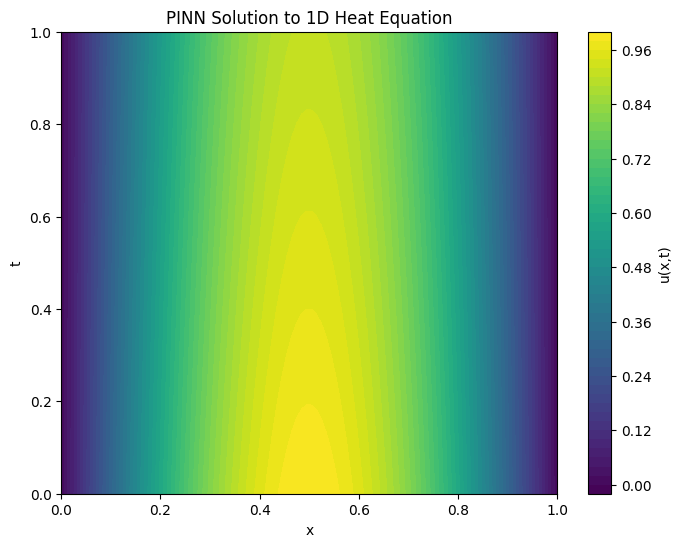

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the neural network
class PINN(nn.Module):
    def __init__(self, num_hidden=32):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.net(inputs)

# Physics-informed loss function
def compute_loss(model, x, t, alpha=0.01):
    x = x.requires_grad_(True)
    t = t.requires_grad_(True)

    u = model(x, t)

    # Compute derivatives
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

    # PDE residual: ∂u/∂t = α ∂²u/∂x²
    pde_residual = u_t - alpha * u_xx
    pde_loss = torch.mean(pde_residual**2)

    # Boundary conditions: u(0,t) = u(1,t) = 0
    bc_left = model(torch.zeros_like(t), t)
    bc_right = model(torch.ones_like(t), t)
    bc_loss = torch.mean(bc_left**2) + torch.mean(bc_right**2)

    # Initial condition: u(x,0) = sin(πx)
    x_ic = torch.linspace(0, 1, 100).reshape(-1, 1)
    t_ic = torch.zeros_like(x_ic)
    u_ic = model(x_ic, t_ic)
    ic_true = torch.sin(np.pi * x_ic)
    ic_loss = torch.mean((u_ic - ic_true)**2)

    return pde_loss + bc_loss + ic_loss

# Training function
def train(model, num_epochs=10000, num_points=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(num_epochs):
        # Sample random points in the domain
        x = torch.rand(num_points, 1)
        t = torch.rand(num_points, 1)

        optimizer.zero_grad()
        loss = compute_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# Plotting function
def plot_solution(model):
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
    t = torch.linspace(0, 1, 100).reshape(-1, 1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)

    with torch.no_grad():
        U = model(X_flat, T_flat).reshape(X.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(X, T, U.numpy(), levels=50, cmap='viridis')
    plt.colorbar(label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('PINN Solution to 1D Heat Equation')
    plt.savefig('heat_equation_solution.png')

# Main execution
if __name__ == '__main__':
    model = PINN()
    train(model, num_epochs=10000)
    plot_solution(model)

In [ ]:
#Define Physics